In [10]:
#PACKAGES
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from statsmodels.tsa.api import SimpleExpSmoothing, Holt, ExponentialSmoothing
# from google.colab import files
import json
from tabulate import tabulate
import os

# DATA
file_path = 'data.json'
with open(file_path,'r') as f:
    json_data = json.load(f)
data = pd.DataFrame(json_data)
display(data.head())


,P/N,DN Price,Qty Per Engine,Qty Per Package,DTM,D-1,D-2,D-3,D-4,D-5,...,C-3,C-4,C-5,C-6,C-7,C-8,C-9,C-10,C-11,C-12
0,129888,2.50,2,12,2,10,6,2,2,12,...,1,1,5,0,4,2,7,4,1,4
1,130083,16.55,6,2,0,4,18,6,6,10,...,1,1,2,4,1,3,2,3,0,1
2,131584,2.58,2,10,2,2,7,6,0,2,...,2,0,1,1,2,4,3,3,0,1
3,132770,16.02,2,1,0,2,0,0,0,2,...,0,0,1,0,0,1,0,0,0,0
4,205230,36.03,34,1,60,60,60,60,60,60,...,2,2,2,3,0,3,1,1,3,1


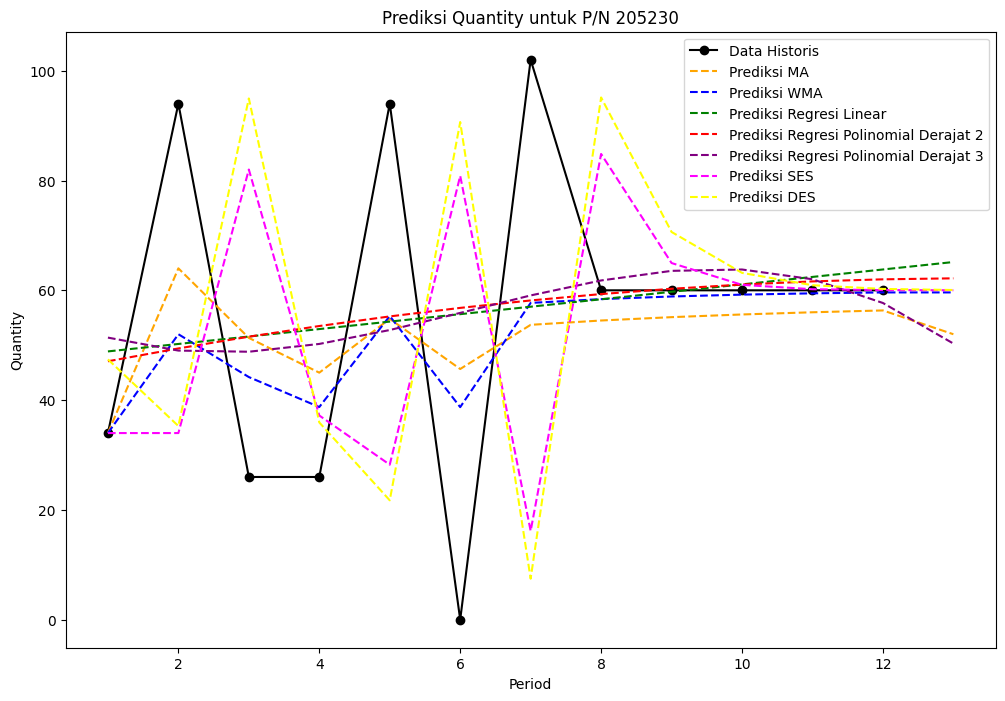

<Figure size 640x480 with 0 Axes>

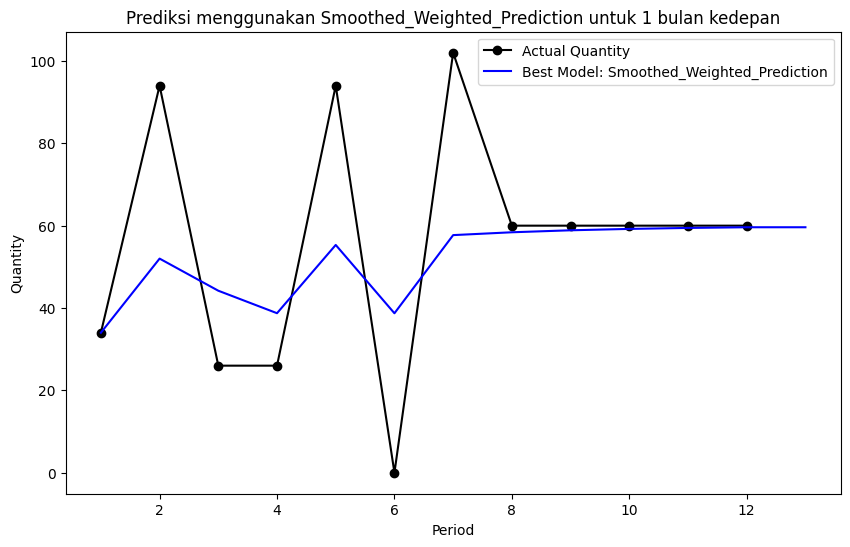

╒════╤════════╤══════════╤════════════╤═════════════════╤════════════════════════════════╤════════════════════════════════╤═════════════════════════════════════════════╤═════════════════════════════════════════════╤══════════════════╤══════════════════╕
│    │    P/N │   Period │   Quantity │   MA_Prediction │   Smoothed_Weighted_Prediction │   Linear_Regression_Prediction │   Polynomial_Regression_Prediction_Degree_2 │   Polynomial_Regression_Prediction_Degree_3 │   SES_Prediction │   DES_Prediction │
╞════╪════════╪══════════╪════════════╪═════════════════╪════════════════════════════════╪════════════════════════════════╪═════════════════════════════════════════════╪═════════════════════════════════════════════╪══════════════════╪══════════════════╡
│  0 │ 205230 │        1 │         34 │         34      │                        34      │                        48.8718 │                                     47.0769 │                                     51.3846 │          34      │    

<Figure size 640x480 with 0 Axes>

In [11]:

def process_pn(data, pn_to_filter):
    filtered_data = data[data['P/N'] == pn_to_filter]
    formatted_data = []
    for index, row in filtered_data.iterrows():
        reversed_quantities = [row[f'D-{i}'] for i in range(1, 13)][::-1] #kalo 2 sampe 13 tinggal ganti range 1 ke 2
        for i, quantity in enumerate(reversed_quantities, start=1): #kalo mulai D-2 start=2
            formatted_data.append({
                'P/N': row['P/N'],
                'Period': i,
                'Quantity': quantity
            })

    formatted_df = pd.DataFrame(formatted_data)

    return formatted_df


# PILIH PN DISINI
pn_to_filter = 205230  # <--- nih yang ini (APABILA MEMILIKI HURUF PAKAI '...')
formatted_df = process_pn(data, pn_to_filter)

# MOVING AVERAGE
last_12_sum = formatted_df['Quantity'].iloc[:12].sum()
formatted_df['MA_Prediction'] = np.nan
for i in range(1, 13): #ini juga sama kalo mulai D-2 range nya 2,13
    formatted_df.loc[formatted_df['Period'] == i, 'MA_Prediction'] = formatted_df['Quantity'].iloc[:i].sum() / i

ma_13th_period = last_12_sum / 13
formatted_df = pd.concat([
    formatted_df,
    pd.DataFrame({'Period': [13], 'MA_Prediction': [ma_13th_period], 'Quantity': [np.nan]})
], ignore_index=True)

# WEIGHTED MOVING AVERAGE
def calculate_exponential_weighted_moving_average(values, alpha=0.2):
    return values.ewm(alpha=alpha, adjust=False).mean()

alpha = 0.3
formatted_df['Smoothed_Weighted_Prediction'] = calculate_exponential_weighted_moving_average(
    formatted_df['Quantity'], alpha
)

# REGRESI LINEAR
valid_data = formatted_df.dropna(subset=['Quantity'])
X = valid_data[['Period']]
y = valid_data['Quantity']
model = LinearRegression()
model.fit(X, y)
formatted_df['Linear_Regression_Prediction'] = model.predict(formatted_df[['Period']])

# POLINOM DERAJAT 2
degree = 2
poly = PolynomialFeatures(degree=degree)
X_poly = poly.fit_transform(X)
poly_model = LinearRegression()
poly_model.fit(X_poly, y)
X_all_poly = poly.transform(formatted_df[['Period']])
formatted_df['Polynomial_Regression_Prediction_Degree_2'] = poly_model.predict(X_all_poly)

# POLINOM DERAJAT 3
degree = 3
poly = PolynomialFeatures(degree=degree)
X_poly = poly.fit_transform(X)
poly_model = LinearRegression()
poly_model.fit(X_poly, y)
X_all_poly = poly.transform(formatted_df[['Period']])
formatted_df['Polynomial_Regression_Prediction_Degree_3'] = poly_model.predict(X_all_poly)

# SINGLE EXPONENTIAL SMOOTHING
alpha_ses = 0.8  # ubah nilai alpha (semakin besar semakin berat ke data terbaru)
beta_des = 0.3   # ubah nilai beta (semakin besar semakin cepat beradaptasi, kalo rendah bisa terjadi lag)
def apply_ses(values, alpha=alpha_ses):
    ses_model = SimpleExpSmoothing(values).fit(smoothing_level=alpha, optimized=False)
    return ses_model.fittedvalues

# DOUBLE EXPONENTIAL SMOOTHING
def apply_des(values, alpha=alpha_ses, beta=beta_des):
    des_model = ExponentialSmoothing(values, trend='add', seasonal=None).fit(smoothing_level=alpha, smoothing_trend=beta, optimized=False)
    return des_model.fittedvalues

formatted_df['SES_Prediction'] = apply_ses(formatted_df['Quantity'], alpha=alpha_ses)
formatted_df['DES_Prediction'] = apply_des(formatted_df['Quantity'], alpha=alpha_ses, beta=beta_des)

# RMSE DAN R2
results = []
for column in ['MA_Prediction', 'Smoothed_Weighted_Prediction', 'Linear_Regression_Prediction', 'Polynomial_Regression_Prediction_Degree_2', 'Polynomial_Regression_Prediction_Degree_3', 'SES_Prediction', 'DES_Prediction']:
    valid_data = formatted_df.dropna(subset=['Quantity', column])
    if valid_data.empty:
        print(f"Skipping {column} due to lack of valid data.")
        continue
    try:
        rmse = np.sqrt(mean_squared_error(valid_data['Quantity'], valid_data[column]))
        r2 = r2_score(valid_data['Quantity'], valid_data[column])
        results.append({'Model': column, 'RMSE': rmse, 'R2': r2})
    except Exception as e:
        print(f"Error evaluating {column}: {e}")

results_df = pd.DataFrame(results)

# BEST R2
best_model_row = results_df.loc[results_df['R2'].idxmax()]
best_model_name = best_model_row['Model']
best_model_r2 = best_model_row['R2']
next_period_prediction = formatted_df.loc[formatted_df['Period'] == 13, best_model_name].values[0]

#print(f"Best Model: {best_model_name}")
#print(f"Best R-squared: {best_model_r2}")
#print(f"Prediction for 13th Period: {next_period_prediction}")

if not os.path.exists('/mnt/data'):
    os.makedirs('/mnt/data')

#PLOT SEMUA GRAFIK
plot_semua_path = '/mnt/data/plotsemua.png'
plt.figure(figsize=(12, 8))
plt.plot(formatted_df['Period'], formatted_df['Quantity'], label='Data Historis', marker='o', color='black')
plt.plot(formatted_df['Period'], formatted_df['MA_Prediction'], label='Prediksi MA', linestyle='--', color='orange')
plt.plot(formatted_df['Period'], formatted_df['Smoothed_Weighted_Prediction'], label='Prediksi WMA', linestyle='--', color='blue')
plt.plot(formatted_df['Period'], formatted_df['Linear_Regression_Prediction'], label='Prediksi Regresi Linear', linestyle='--', color='green')
plt.plot(formatted_df['Period'], formatted_df['Polynomial_Regression_Prediction_Degree_2'], label='Prediksi Regresi Polinomial Derajat 2', linestyle='--', color='red')
plt.plot(formatted_df['Period'], formatted_df['Polynomial_Regression_Prediction_Degree_3'], label='Prediksi Regresi Polinomial Derajat 3', linestyle='--', color='purple' )
plt.plot(formatted_df['Period'], formatted_df['SES_Prediction'], label='Prediksi SES', linestyle='--', color='magenta' )
plt.plot(formatted_df['Period'], formatted_df['DES_Prediction'], label='Prediksi DES', linestyle='--', color='yellow' )
plt.xlabel('Period')
plt.ylabel('Quantity')
plt.title(f'Prediksi Quantity untuk P/N {pn_to_filter}')
plt.legend()
plt.grid(False)
plt.show()
plt.savefig(plot_semua_path)
#files.download(plot_semua_path)

# PLOT GRAFIK PALING BAGUS
plot_best_path = '/mnt/data/plotbest.png'
plt.figure(figsize=(10, 6))
plt.plot(formatted_df['Period'], formatted_df['Quantity'], label='Actual Quantity', marker='o', color='black')
plt.plot(formatted_df['Period'], formatted_df[best_model_name], label=f'Best Model: {best_model_name}', linestyle='-', color='blue')
plt.xlabel('Period')
plt.ylabel('Quantity')
plt.title(f'Prediksi menggunakan {best_model_name} untuk 1 bulan kedepan')
plt.legend()
plt.grid(False)
plt.show()
plt.savefig(plot_best_path)
#files.download(plot_best_path)

# Print formatted_df as a table
print(tabulate(formatted_df, headers='keys', tablefmt='fancy_grid'))
print(tabulate(results_df.sort_values(by='R2', ascending=False), headers='keys', tablefmt='fancy_grid'))
table_data = [
    ["P/N", pn_to_filter],
    ["Best Model", best_model_name],
    ["Best R-squared", f"{best_model_r2:.4f}"],
    ["Prediction for 13th Period", f"{next_period_prediction:.6f}"]
]
print(tabulate(table_data, headers=["Metric", "Value"], tablefmt="fancy_grid"))

# Export the DataFrame to a JSON file
output_file_path = 'results.json'
formatted_df.to_json(output_file_path, orient='records', indent=4)
formatted_df.to_excel('result.xlsx', index=False)
print(f"Data saved to {output_file_path}")

#Export the pictures to a JSON file
output_file_path = 'pictures.json'



In [4]:
#interactive plot
import plotly.graph_objects as go

# Create an interactive line plot
fig = go.Figure()

# Add traces for each prediction and the actual data
fig.add_trace(go.Scatter(x=formatted_df['Period'], y=formatted_df['Quantity'],
                         mode='lines+markers', name='Data Historis', line=dict(color='black')))
fig.add_trace(go.Scatter(x=formatted_df['Period'], y=formatted_df['MA_Prediction'],
                         mode='lines', name='Prediksi MA', line=dict(dash='dash', color='orange')))
fig.add_trace(go.Scatter(x=formatted_df['Period'], y=formatted_df['Smoothed_Weighted_Prediction'],
                         mode='lines', name='Prediksi WMA', line=dict(dash='dash', color='blue')))
fig.add_trace(go.Scatter(x=formatted_df['Period'], y=formatted_df['Linear_Regression_Prediction'],
                         mode='lines', name='Prediksi Regresi Linear', line=dict(dash='dash', color='green')))
fig.add_trace(go.Scatter(x=formatted_df['Period'], y=formatted_df['Polynomial_Regression_Prediction_Degree_2'],
                         mode='lines', name='Prediksi Regresi Polinomial Derajat 2', line=dict(dash='dash', color='red')))
fig.add_trace(go.Scatter(x=formatted_df['Period'], y=formatted_df['Polynomial_Regression_Prediction_Degree_3'],
                         mode='lines', name='Prediksi Regresi Polinomial Derajat 3', line=dict(dash='dash', color='purple')))
fig.add_trace(go.Scatter(x=formatted_df['Period'], y=formatted_df['SES_Prediction'],
                         mode='lines', name='Prediksi SES', line=dict(dash='dash', color='magenta')))
fig.add_trace(go.Scatter(x=formatted_df['Period'], y=formatted_df['DES_Prediction'],
                         mode='lines', name='Prediksi DES', line=dict(dash='dash', color='yellow')))

# Customize layout
fig.update_layout(title=f'Interactive Quantity Prediction for P/N {pn_to_filter}',
                  xaxis_title='Period',
                  yaxis_title='Quantity',
                  legend_title='Prediction Models',
                  template='plotly_white')

# Show the plot
fig.show()
